# *Quantifying Cost of Infrastructure Needs*


In [195]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.interpolate import make_interp_spline, UnivariateSpline
import numpy as np
import json
from json import JSONEncoder
import ast
import seaborn as sns
import warnings
os.environ['USE_PYGEOS']='0' # Hva er dette?

# Display all columns in the df
pd.set_option('display.max_columns', None)
# Set the float format to display numbers in standard decimal notation
pd.options.display.float_format = '{:.5f}'.format
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [196]:
df=pd.read_csv(r'/Users/antonglad/Desktop/Python_Recreation/all_roads_without_cs_02.csv')
df


,Unnamed: 0,source,target,length,Name_2,ID_2,geometry,unique_id
0,28,954272,279457,10460.10809,NaN,NaN,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457
1,42,1306725,892553,16944.55074,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553
2,43,1306725,613853,17910.82374,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_613853
3,44,1306725,246612,11239.09381,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_246612
4,45,626111,246612,12162.60912,NaN,NaN,MULTILINESTRING ((9.525987851154536 59.6316909...,626111_246612
...,...,...,...,...,...,...,...,...
253,297,973638,973930,16599.43953,NaN,NaN,MULTILINESTRING ((26.139194165036866 70.302533...,973638_973930
254,298,973930,1818925,15500.51499,NaN,NaN,MULTILINESTRING ((26.565130981516866 70.341708...,973930_1818925
255,299,832749,1101914,17561.22246,NaN,NaN,MULTILINESTRING ((27.33086343693628 70.4436216...,832749_1101914
256,300,1101914,1007500,15461.23499,NaN,NaN,MULTILINESTRING ((27.80045221095047 70.4386256...,1101914_1007500


**Adding the volume of roads without charging stations**<br>
This is necessary in order to calculate the demand theoretically needed to classify these roads as served

## Adding traffic to these points

In [197]:
df=pd.read_csv(r"/Users/antonglad/Desktop/Python_Recreation/missingCS_data_with_volume.csv")
df.head(5)

,Unnamed: 0,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,1,2,3,4,5,6,7,8,9,10,11,12
0,0,954272,279457,10460.10809,NaN,NaN,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,NaN,NaN,NaN,NaN,NaN
1,3,1306725,892553,16944.55074,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN
2,8,1306725,613853,17910.82374,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_613853,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN
3,13,1306725,246612,11239.09381,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_246612,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN
4,18,626111,246612,12162.60912,NaN,NaN,MULTILINESTRING ((9.525987851154536 59.6316909...,626111_246612,36539V181297,2125.00000,2125.00000,2523.00000,2577.00000,2277.00000,2382.00000,2768.00000,3337.00000,3112.00000,2881.00000,2694.00000,2188.00000,2101.00000


In [198]:
#Data cleaning and appending required parameters
df = df.drop("Unnamed: 0", axis=1)
df.info()

#Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
df["range"]=300

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   source      258 non-null    int64  
 1   target      258 non-null    int64  
 2   length      258 non-null    float64
 3   Name_2      0 non-null      float64
 4   ID_2        0 non-null      float64
 5   geometry    258 non-null    object 
 6   unique_id   258 non-null    object 
 7   traffic_id  258 non-null    object 
 8   volume      257 non-null    float64
 9   1           255 non-null    float64
 10  2           255 non-null    float64
 11  3           255 non-null    float64
 12  4           255 non-null    float64
 13  5           255 non-null    float64
 14  6           253 non-null    float64
 15  7           248 non-null    float64
 16  8           249 non-null    float64
 17  9           246 non-null    float64
 18  10          244 non-null    float64
 19  11          247 non-null    f

In [199]:
#Change names of volume columns
new_names = {'1': 'vol_jan', '2': 'vol_feb', '3': 'vol_mar', '4': 'vol_apr', '5': 'vol_may', '6': 'vol_jun', '7': 'vol_jul', '8': 'vol_aug', '9': 'vol_sep', '10': 'vol_oct', '11': 'vol_nov', '12': 'vol_dec'}

df = df.rename(columns=new_names)

In [200]:
df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range
0,954272,279457,10460.10809,NaN,NaN,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,NaN,NaN,NaN,NaN,NaN,300
1,1306725,892553,16944.55074,NaN,NaN,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,NaN,12423.00000,NaN,NaN,NaN,NaN,300


In [201]:
# Data exploration: "Does these roads contain a lot of traffic?"
# Find the maximum value in the "volume" column
max_value = df["volume"].max()

# Print the maximum value
print("Max value of 'volume' column:", max_value)

Max value of 'volume' column: 16810.0


In [202]:
# There are some NaN values in some of the roads, filling with the mean of the same roads other months is satisfactory

# Loop through each row of the dataframe
for index, row in df.iterrows():
    # Calculate the mean of the non-missing values in the row
    row_mean = row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True)

    # Fill the missing values in the row with the row mean
    df.loc[index] = row.fillna(row_mean)

In [203]:
df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range
0,954272,279457,10460.10809,1131.28571,1131.28571,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.28571,1131.28571,1131.28571,1131.28571,1131.28571,300
1,1306725,892553,16944.55074,11132.14286,11132.14286,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.14286,12423.00000,11132.14286,11132.14286,11132.14286,11132.14286,300


In [204]:
# Creating dictionary showcasing the loss of range per season (recall this dictionary from the Mainfram notebook, calculated in Battery_Range.xlsx)
temp_cost={'january':0.8, 
           'february':0.8, 
           'march':0.8, 
           'april':0.9, 
           'may':1, 
           'june':1.05, 
           'july':1.1, 
           'august':1.1, 
           'september':1.02, 
           'october':0.92, 
           'november':0.82, 
           'december':0.8} 


# Methodology for finding actual range of EV's can be improved. Take into account battery aging, and recommended charging to 80% (actual percentage can be researched)
# Sensitivities on vehicle range can also be performed, some vehicles have less range and some have more. (It affects the probability of needing to charge quite a lot. Experiment with it!)

# Calulating actual length. EV Battery effect on season-temperature.
for key in temp_cost.keys():
   df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]

df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec
0,954272,279457,10460.10809,1131.28571,1131.28571,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.28571,1131.28571,1131.28571,1131.28571,1131.28571,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000
1,1306725,892553,16944.55074,11132.14286,11132.14286,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.14286,12423.00000,11132.14286,11132.14286,11132.14286,11132.14286,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000


In [205]:
# Creating probabilities of drivers needing to charge on any given road. {For each month, for each road}
for month in temp_cost.keys():
    col_name = f"charge_prob_{month[:3].lower()}"                                           # Create a new column name for the charging probability
    df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)          # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)

df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec
0,954272,279457,10460.10809,1131.28571,1131.28571,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.28571,1131.28571,1131.28571,1131.28571,1131.28571,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.04358,0.04358,0.04358,0.03874,0.03487,0.03321,0.03170,0.03170,0.03418,0.03790,0.04252,0.04358
1,1306725,892553,16944.55074,11132.14286,11132.14286,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.14286,12423.00000,11132.14286,11132.14286,11132.14286,11132.14286,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.07060,0.07060,0.07060,0.06276,0.05648,0.05379,0.05135,0.05135,0.05537,0.06139,0.06888,0.07060


In [206]:
#This charge cars must be multiplied with a EV-ratio of the entire Norwegian vehicle fleet (which is around 16-20% as of 04/06/2020) 

#Could be either multiplied by each norwegian region or use one number for the whole country, in our experiment we use one ratio for the whole country. Further testing is conducted in sensitivity analysis
ev_ratio= 0.2
#public_charging=X #This ratio can be used to further increase the accuracy of [cars charging]

# Loop through each month in the temp_cost dictionary
for month in temp_cost.keys():
    # Create a new column name for the charging probability
    col_name = f"charge_cars_{month[:3].lower()}"
    # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
    df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio) #*public_charging
    df[col_name] = df[col_name]

df.head(2)

,source,target,length,Name_2,ID_2,geometry,unique_id,traffic_id,volume,vol_jan,vol_feb,vol_mar,vol_apr,vol_may,vol_jun,vol_jul,vol_aug,vol_sep,vol_oct,vol_nov,vol_dec,range,actual_range_jan,actual_range_feb,actual_range_mar,actual_range_apr,actual_range_may,actual_range_jun,actual_range_jul,actual_range_aug,actual_range_sep,actual_range_oct,actual_range_nov,actual_range_dec,charge_prob_jan,charge_prob_feb,charge_prob_mar,charge_prob_apr,charge_prob_may,charge_prob_jun,charge_prob_jul,charge_prob_aug,charge_prob_sep,charge_prob_oct,charge_prob_nov,charge_prob_dec,charge_cars_jan,charge_cars_feb,charge_cars_mar,charge_cars_apr,charge_cars_may,charge_cars_jun,charge_cars_jul,charge_cars_aug,charge_cars_sep,charge_cars_oct,charge_cars_nov,charge_cars_dec
0,954272,279457,10460.10809,1131.28571,1131.28571,MULTILINESTRING ((9.038838694405207 58.7554120...,954272_279457,15882V21841,948.00000,948.00000,1066.00000,1116.00000,1086.00000,1154.00000,1255.00000,1294.00000,1131.28571,1131.28571,1131.28571,1131.28571,1131.28571,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.04358,0.04358,0.04358,0.03874,0.03487,0.03321,0.03170,0.03170,0.03418,0.03790,0.04252,0.04358,8.26349,9.29206,9.72790,8.41458,8.04731,8.33488,8.20326,7.17174,7.73423,8.57491,9.62063,9.86114
1,1306725,892553,16944.55074,11132.14286,11132.14286,MULTILINESTRING ((9.782295476831635 59.7062784...,1306725_892553,08002V181261,10201.00000,10201.00000,11083.00000,10841.00000,10668.00000,10862.00000,11847.00000,11132.14286,12423.00000,11132.14286,11132.14286,11132.14286,11132.14286,300,240.00000,240.00000,240.00000,270.00000,300,315.00000,330.00000,330.00000,306.00000,276.00000,246.00000,240.00000,0.07060,0.07060,0.07060,0.06276,0.05648,0.05379,0.05135,0.05135,0.05537,0.06139,0.06888,0.07060,144.04280,156.49705,153.07990,133.89961,122.70114,127.45530,114.32070,127.57706,123.28703,136.68780,153.35704,157.19097


In [207]:
new_names_2 = {'source': 'u', 'target': 'v'}

df = df.rename(columns=new_names_2) 

In [208]:
edges = df[['u', 'v']].values.tolist()                                  # Get all pairs of 'u' and 'v' which makes the edge (u = source, v = target) 
edge_counts = pd.Series(edges).value_counts(normalize=False)            # Get the count of each unique edge
print(edge_counts)                                                      # Print the unique edge and its counts
print('----------------------------------------------------')
pair_counts_sum = edge_counts.sum()                                     # Get the sum of all edges
print("Sum of all observations (CS) on all edges: ", pair_counts_sum)   # Print the sum of all edges
print('----------------------------------------------------')
one_obs_count = (edge_counts == 1).sum()                                # Get the count of edges with a count of 1
print("edges with only one observation (CS): ", one_obs_count)          # Print the count of edges with only one observation ()
print('----------------------------------------------------')

[954272, 279457]      1
[968532, 761920]      1
[75715, 192932]       1
[75715, 75167]        1
[75167, 173678]       1
                     ..
[658802, 474129]      1
[474672, 475387]      1
[1600133, 355270]     1
[467676, 1123339]     1
[1007500, 1594521]    1
Length: 258, dtype: int64
----------------------------------------------------
Sum of all observations (CS) on all edges:  258
----------------------------------------------------
edges with only one observation (CS):  258
----------------------------------------------------


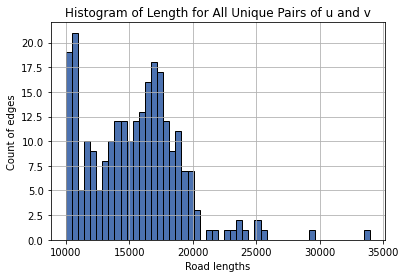

In [209]:
# "What are the lengths of the roads without charging stations?"
pairs_hist = df[['u', 'v']].drop_duplicates().values.tolist()                                   # Get all unique pairs of 'u' and 'v' columns in the DataFrame
lengths = pd.concat([df[(df['u'] == u) & (df['v'] == v)]['length'] for u, v in pairs_hist])     # Concatenate the length column from all subset DataFrames into a single DataFrame

# Create a histogram of the concatenated length column
lengths.hist(bins=50, edgecolor='black')
plt.xlabel('Road lengths')
plt.ylabel('Count of edges')
plt.title('Histogram of Length for All Unique Pairs of u and v')
plt.show()




In [210]:
#Investigating real traffic hourly patterns of the day based on real data (not pivoted spreadsheet)
hourly=pd.read_csv(r"/Users/antonglad/Desktop/Python_Recreation/completeAllHourlyVolume_EasterAprJulSep.csv")
hourly.head()

total_traffic_by_hour = hourly.groupby(['from_hour'])['volume'].sum()       # Group the DataFrame by hour and sum the traffic volume
total_traffic = hourly['volume'].sum()                                      # Calculate the total traffic volume for the entire day
mean_ratios = total_traffic_by_hour / total_traffic                         # Calculate the mean ratio for each hour of the day


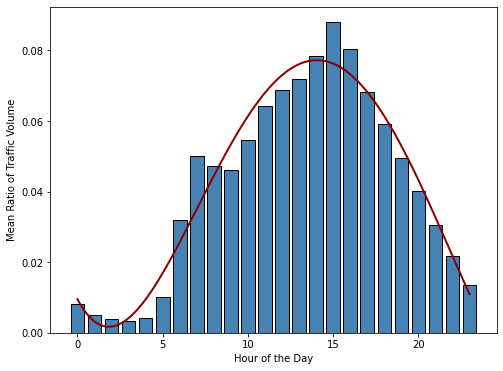

In [211]:
#Historgam displaying the distribution of traffic during the day (calculated based on averages of hundreds of traffic points from different weeks spread out across the year)

mean_ratios_list = mean_ratios.tolist()         # Convert the mean ratios to a list
hours = mean_ratios.index.tolist()              # Create a list of the hour values

# Extract just the hour from the from_hour column
hours = [int(x.split(':')[0]) for x in hours]  # Convert to integers 

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(hours, mean_ratios_list, edgecolor='black', color="steelblue")       # Create the histogram
ax.set_xlabel('Hour of the Day')                                            # Set the x-axis label
ax.set_ylabel('Mean Ratio of Traffic Volume')                               # Set the y-axis label
x_smooth = np.linspace(min(hours), max(hours), 200)                         # Generate the spline
#spl = make_interp_spline(hours, mean_ratios_list, k=3)                     #Smoothing method 1 : more precise (less nice)
spl = UnivariateSpline(hours, mean_ratios_list, k=4, s=1)                   # Smoothing method 2 : less precise, more smooth (more nice)
y_smooth = spl(x_smooth)
ax.plot(x_smooth, y_smooth, 'r-', color="darkred", lw=2)                    # Add the spline to the plot

plt.show()# Show the plot

In [212]:
#Creating dataframes with traffic for each a day of each month with every hour

# Extract hour ratios from mean_ratios
hour_ratios = mean_ratios.values.tolist()


# Prepare a list of month abbreviations
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Initialize an empty dictionary to store the DataFrames for each month
monthly_dfs = {}

# Iterate over each month
for month in months:
    # Create a new DataFrame with the same index as new_df
    monthly_df = df[['u', 'v']].copy()
    
    # Distribute cars for each edge and each hour of the day
    for hour, ratio in enumerate(hour_ratios):
        hourly_column_name = f'hour_{hour:02d}_{month}'
        monthly_df[hourly_column_name] = df[f'charge_cars_{month}'].mul(ratio)

        monthly_df["max_hourly_value"] = monthly_df.drop(columns=['u', 'v']).max(axis=1)

    
    # Store the resulting DataFrame in the dictionary
    monthly_dfs[month] = monthly_df

In [213]:
# Initialize an empty list to store all the dataframes
all_dfs = []

# Iterate over each month and dataframe
for month, df in monthly_dfs.items():
    # Rename the columns to include the month as a suffix
    df = df.rename(columns=lambda x: f'{x}_{month}' if 'hour' in x else x)
    # Append the dataframe to the list
    all_dfs.append(df)

# Use merge to join all dataframes on 'u' and 'v'
from functools import reduce

merged_df = reduce(lambda  left,right: pd.merge(left, right, on=['u', 'v'], how='outer'), all_dfs)

In [214]:
hourly_columns = [col for col in merged_df.columns if 'hour' in col]
merged_df['max_hourly_value'] = merged_df[hourly_columns].max(axis=1)

In [215]:
merged_df.head(5)

,u,v,hour_00_jan_jan,max_hourly_value_jan,hour_01_jan_jan,hour_02_jan_jan,hour_03_jan_jan,hour_04_jan_jan,hour_05_jan_jan,hour_06_jan_jan,hour_07_jan_jan,hour_08_jan_jan,hour_09_jan_jan,hour_10_jan_jan,hour_11_jan_jan,hour_12_jan_jan,hour_13_jan_jan,hour_14_jan_jan,hour_15_jan_jan,hour_16_jan_jan,hour_17_jan_jan,hour_18_jan_jan,hour_19_jan_jan,hour_20_jan_jan,hour_21_jan_jan,hour_22_jan_jan,hour_23_jan_jan,hour_00_feb_feb,max_hourly_value_feb,hour_01_feb_feb,hour_02_feb_feb,hour_03_feb_feb,hour_04_feb_feb,hour_05_feb_feb,hour_06_feb_feb,hour_07_feb_feb,hour_08_feb_feb,hour_09_feb_feb,hour_10_feb_feb,hour_11_feb_feb,hour_12_feb_feb,hour_13_feb_feb,hour_14_feb_feb,hour_15_feb_feb,hour_16_feb_feb,hour_17_feb_feb,hour_18_feb_feb,hour_19_feb_feb,hour_20_feb_feb,hour_21_feb_feb,hour_22_feb_feb,hour_23_feb_feb,hour_00_mar_mar,max_hourly_value_mar,hour_01_mar_mar,hour_02_mar_mar,hour_03_mar_mar,hour_04_mar_mar,hour_05_mar_mar,hour_06_mar_mar,hour_07_mar_mar,hour_08_mar_mar,hour_09_mar_mar,hour_10_mar_mar,hour_11_mar_mar,hour_12_mar_mar,hour_13_mar_mar,hour_14_mar_mar,hour_15_mar_mar,hour_16_mar_mar,hour_17_mar_mar,hour_18_mar_mar,hour_19_mar_mar,hour_20_mar_mar,hour_21_mar_mar,hour_22_mar_mar,hour_23_mar_mar,hour_00_apr_apr,max_hourly_value_apr,hour_01_apr_apr,hour_02_apr_apr,hour_03_apr_apr,hour_04_apr_apr,hour_05_apr_apr,hour_06_apr_apr,hour_07_apr_apr,hour_08_apr_apr,hour_09_apr_apr,hour_10_apr_apr,hour_11_apr_apr,hour_12_apr_apr,hour_13_apr_apr,hour_14_apr_apr,hour_15_apr_apr,hour_16_apr_apr,hour_17_apr_apr,hour_18_apr_apr,hour_19_apr_apr,hour_20_apr_apr,hour_21_apr_apr,hour_22_apr_apr,hour_23_apr_apr,hour_00_may_may,max_hourly_value_may,hour_01_may_may,hour_02_may_may,hour_03_may_may,hour_04_may_may,hour_05_may_may,hour_06_may_may,hour_07_may_may,hour_08_may_may,hour_09_may_may,hour_10_may_may,hour_11_may_may,hour_12_may_may,hour_13_may_may,hour_14_may_may,hour_15_may_may,hour_16_may_may,hour_17_may_may,hour_18_may_may,hour_19_may_may,hour_20_may_may,hour_21_may_may,hour_22_may_may,hour_23_may_may,hour_00_jun_jun,max_hourly_value_jun,hour_01_jun_jun,hour_02_jun_jun,hour_03_jun_jun,hour_04_jun_jun,hour_05_jun_jun,hour_06_jun_jun,hour_07_jun_jun,hour_08_jun_jun,hour_09_jun_jun,hour_10_jun_jun,hour_11_jun_jun,hour_12_jun_jun,hour_13_jun_jun,hour_14_jun_jun,hour_15_jun_jun,hour_16_jun_jun,hour_17_jun_jun,hour_18_jun_jun,hour_19_jun_jun,hour_20_jun_jun,hour_21_jun_jun,hour_22_jun_jun,hour_23_jun_jun,hour_00_jul_jul,max_hourly_value_jul,hour_01_jul_jul,hour_02_jul_jul,hour_03_jul_jul,hour_04_jul_jul,hour_05_jul_jul,hour_06_jul_jul,hour_07_jul_jul,hour_08_jul_jul,hour_09_jul_jul,hour_10_jul_jul,hour_11_jul_jul,hour_12_jul_jul,hour_13_jul_jul,hour_14_jul_jul,hour_15_jul_jul,hour_16_jul_jul,hour_17_jul_jul,hour_18_jul_jul,hour_19_jul_jul,hour_20_jul_jul,hour_21_jul_jul,hour_22_jul_jul,hour_23_jul_jul,hour_00_aug_aug,max_hourly_value_aug,hour_01_aug_aug,hour_02_aug_aug,hour_03_aug_aug,hour_04_aug_aug,hour_05_aug_aug,hour_06_aug_aug,hour_07_aug_aug,hour_08_aug_aug,hour_09_aug_aug,hour_10_aug_aug,hour_11_aug_aug,hour_12_aug_aug,hour_13_aug_aug,hour_14_aug_aug,hour_15_aug_aug,hour_16_aug_aug,hour_17_aug_aug,hour_18_aug_aug,hour_19_aug_aug,hour_20_aug_aug,hour_21_aug_aug,hour_22_aug_aug,hour_23_aug_aug,hour_00_sep_sep,max_hourly_value_sep,hour_01_sep_sep,hour_02_sep_sep,hour_03_sep_sep,hour_04_sep_sep,hour_05_sep_sep,hour_06_sep_sep,hour_07_sep_sep,hour_08_sep_sep,hour_09_sep_sep,hour_10_sep_sep,hour_11_sep_sep,hour_12_sep_sep,hour_13_sep_sep,hour_14_sep_sep,hour_15_sep_sep,hour_16_sep_sep,hour_17_sep_sep,hour_18_sep_sep,hour_19_sep_sep,hour_20_sep_sep,hour_21_sep_sep,hour_22_sep_sep,hour_23_sep_sep,hour_00_oct_oct,max_hourly_value_oct,hour_01_oct_oct,hour_02_oct_oct,hour_03_oct_oct,hour_04_oct_oct,hour_05_oct_oct,hour_06_oct_oct,hour_07_oct_oct,hour_08_oct_oct,hour_09_oct_oct,hour_10_oct_oct,hour_11_oct_oct,hour_12_oct_oct,hour_13_oct_oct,hour_14_oct_oct,hour_15_oct_oct,hour_16_oct_oct,hour_17_oct_oct,hour_18_oct_oct,hour_19_oct_oct,hour_20_o

**The next steps involve finding when the demand is at its highest for each road.<br>**
**This max value will be the minimum supply needed for each road to be classified as served**

In [216]:
# Extract wanted data for roads
max_hourly_df = merged_df[['u', 'v', 'max_hourly_value']].copy()
max_hourly_df.head(4)

,u,v,max_hourly_value
0,954272,279457,0.86783
1,1306725,892553,13.83362
2,1306725,613853,14.62249
3,1306725,246612,9.17566


In [217]:
#Recall the capabiilties of chargers

# Define the kW types of chargers
kW_list = [350, 300, 250, 200, 180, 175, 150, 135, 129, 125, 120, 100, 75, 62.5, 62, 60, 55, 50, 48, 44, 43]

# Define the average battery capacity, Source: https://www.solarquotes.com.au/blog/norway-ev-batteries/
average_battery_capacity = 68

battery_aging_ratio=0.9

average_battery_capacity *= battery_aging_ratio

# Define the setup and takedown time (in minutes)
setup_takedown_time = 5

# Convert setup and takedown time to hours
setup_takedown_time_hours = setup_takedown_time / 60

# Initialize an empty dictionary
cars_per_hour_dict = {}

# Loop through the kW list
for kW in kW_list:
    # Calculate charging time
    charging_time = average_battery_capacity / kW

    # Add the setup and takedown time to the charging time
    total_time = charging_time + setup_takedown_time_hours

    # Calculate cars per hour and round it to 1 decimal place
    cars_per_hour = round(1 / total_time, 1)

    # Add this to the dictionary
    cars_per_hour_dict[kW] = cars_per_hour

# Print out the resulting dictionary
for kW, cars_per_hour in cars_per_hour_dict.items():
    print(f"{kW}: {cars_per_hour}")

350: 3.9
300: 3.5
250: 3.0
200: 2.6
180: 2.4
175: 2.3
150: 2.0
135: 1.9
129: 1.8
125: 1.7
120: 1.7
100: 1.4
75: 1.1
62.5: 0.9
62: 0.9
60: 0.9
55: 0.8
50: 0.8
48: 0.7
44: 0.7
43: 0.7


In [218]:
# We are imagining scenarios for how many chargers at 150kw or 50kw would be needed to 
# cover demand of all roads in Norway that currently do not have chargers.
# We are using 150 and 50kw examples as they are the most frequent types in the Norwegian charging infrastructure


# Constants representing the number of cars each charger type can serve in an hour
CARS_PER_HOUR_50KW = cars_per_hour_dict[50]
CARS_PER_HOUR_150KW = cars_per_hour_dict[150]

# Calculate number of each charger type needed to fulfill the max hourly volume
max_hourly_df["50kw_needed"] = np.ceil(max_hourly_df["max_hourly_value"] / CARS_PER_HOUR_50KW)
max_hourly_df["150kw_needed"] = np.ceil(max_hourly_df["max_hourly_value"] / CARS_PER_HOUR_150KW)

# Convert '50kw_needed' and '150kw_needed' to integer
max_hourly_df["50kw_needed"] = max_hourly_df["50kw_needed"]
max_hourly_df["150kw_needed"] = max_hourly_df["150kw_needed"]

# Calculate the total number of each type of charger needed
total_50kw_needed = max_hourly_df["50kw_needed"].sum()
total_150kw_needed = max_hourly_df["150kw_needed"].sum()

print("Total 50kw chargers needed: ", total_50kw_needed)
print("Total 150kw chargers needed: ", total_150kw_needed)


Total 50kw chargers needed:  951.0
Total 150kw chargers needed:  460.0


In [219]:
#Given a price of $100.000 for one 50kw charger
cost_of_150w=1000000*total_150kw_needed
print("Cost of production of 150w chargers needed: ", cost_of_150w.astype(int))

#Given a price of $50.000 for one 50kw charger
cost_of_50w=500000*total_50kw_needed
print("Cost of production of 50w chargers needed: ", cost_of_50w.astype(int))

#Source: https://futureenergy.com/ev-charging/what-does-a-level-3-charger-cost/

Cost of production of 150w chargers needed:  460000000
Cost of production of 50w chargers needed:  475500000


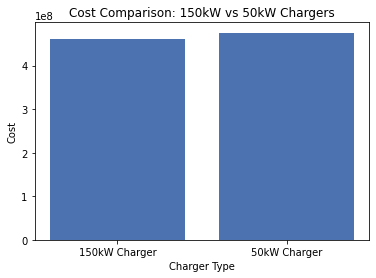

In [220]:
import matplotlib.pyplot as plt

# Create a list of the charger types
charger_types = ['150kW Charger', '50kW Charger']

# Create a list of the corresponding costs
costs = [cost_of_150w, cost_of_50w]

# Plot the costs as a bar plot
plt.bar(charger_types, costs)
plt.xlabel('Charger Type')
plt.ylabel('Cost')
plt.title('Cost Comparison: 150kW vs 50kW Chargers')
plt.show()

## Part 2: Analyzing roads with a supply deficit


### If we want to make the underserved edges served ... <br>
Keep in mind that these are different roads than then ones calculated above. These roads have chargers, but not enough...

In [221]:
import pandas as pd

underserved=pd.read_csv(r"/Users/antonglad/Desktop/Python_Recreation/sensitivity/all_monthly_data.csv")

underserved.head(3)

,u,v,diff_hour_00_jan_jan,diff_hour_01_jan_jan,diff_hour_02_jan_jan,diff_hour_03_jan_jan,diff_hour_04_jan_jan,diff_hour_05_jan_jan,diff_hour_06_jan_jan,diff_hour_07_jan_jan,diff_hour_08_jan_jan,diff_hour_09_jan_jan,diff_hour_10_jan_jan,diff_hour_11_jan_jan,diff_hour_12_jan_jan,diff_hour_13_jan_jan,diff_hour_14_jan_jan,diff_hour_15_jan_jan,diff_hour_16_jan_jan,diff_hour_17_jan_jan,diff_hour_18_jan_jan,diff_hour_19_jan_jan,diff_hour_20_jan_jan,diff_hour_21_jan_jan,diff_hour_22_jan_jan,diff_hour_23_jan_jan,diff_hour_00_feb_feb,diff_hour_01_feb_feb,diff_hour_02_feb_feb,diff_hour_03_feb_feb,diff_hour_04_feb_feb,diff_hour_05_feb_feb,diff_hour_06_feb_feb,diff_hour_07_feb_feb,diff_hour_08_feb_feb,diff_hour_09_feb_feb,diff_hour_10_feb_feb,diff_hour_11_feb_feb,diff_hour_12_feb_feb,diff_hour_13_feb_feb,diff_hour_14_feb_feb,diff_hour_15_feb_feb,diff_hour_16_feb_feb,diff_hour_17_feb_feb,diff_hour_18_feb_feb,diff_hour_19_feb_feb,diff_hour_20_feb_feb,diff_hour_21_feb_feb,diff_hour_22_feb_feb,diff_hour_23_feb_feb,diff_hour_00_mar_mar,diff_hour_01_mar_mar,diff_hour_02_mar_mar,diff_hour_03_mar_mar,diff_hour_04_mar_mar,diff_hour_05_mar_mar,diff_hour_06_mar_mar,diff_hour_07_mar_mar,diff_hour_08_mar_mar,diff_hour_09_mar_mar,diff_hour_10_mar_mar,diff_hour_11_mar_mar,diff_hour_12_mar_mar,diff_hour_13_mar_mar,diff_hour_14_mar_mar,diff_hour_15_mar_mar,diff_hour_16_mar_mar,diff_hour_17_mar_mar,diff_hour_18_mar_mar,diff_hour_19_mar_mar,diff_hour_20_mar_mar,diff_hour_21_mar_mar,diff_hour_22_mar_mar,diff_hour_23_mar_mar,diff_hour_00_apr_apr,diff_hour_01_apr_apr,diff_hour_02_apr_apr,diff_hour_03_apr_apr,diff_hour_04_apr_apr,diff_hour_05_apr_apr,diff_hour_06_apr_apr,diff_hour_07_apr_apr,diff_hour_08_apr_apr,diff_hour_09_apr_apr,diff_hour_10_apr_apr,diff_hour_11_apr_apr,diff_hour_12_apr_apr,diff_hour_13_apr_apr,diff_hour_14_apr_apr,diff_hour_15_apr_apr,diff_hour_16_apr_apr,diff_hour_17_apr_apr,diff_hour_18_apr_apr,diff_hour_19_apr_apr,diff_hour_20_apr_apr,diff_hour_21_apr_apr,diff_hour_22_apr_apr,diff_hour_23_apr_apr,diff_hour_00_may_may,diff_hour_01_may_may,diff_hour_02_may_may,diff_hour_03_may_may,diff_hour_04_may_may,diff_hour_05_may_may,diff_hour_06_may_may,diff_hour_07_may_may,diff_hour_08_may_may,diff_hour_09_may_may,diff_hour_10_may_may,diff_hour_11_may_may,diff_hour_12_may_may,diff_hour_13_may_may,diff_hour_14_may_may,diff_hour_15_may_may,diff_hour_16_may_may,diff_hour_17_may_may,diff_hour_18_may_may,diff_hour_19_may_may,diff_hour_20_may_may,diff_hour_21_may_may,diff_hour_22_may_may,diff_hour_23_may_may,diff_hour_00_jun_jun,diff_hour_01_jun_jun,diff_hour_02_jun_jun,diff_hour_03_jun_jun,diff_hour_04_jun_jun,diff_hour_05_jun_jun,diff_hour_06_jun_jun,diff_hour_07_jun_jun,diff_hour_08_jun_jun,diff_hour_09_jun_jun,diff_hour_10_jun_jun,diff_hour_11_jun_jun,diff_hour_12_jun_jun,diff_hour_13_jun_jun,diff_hour_14_jun_jun,diff_hour_15_jun_jun,diff_hour_16_jun_jun,diff_hour_17_jun_jun,diff_hour_18_jun_jun,diff_hour_19_jun_jun,diff_hour_20_jun_jun,diff_hour_21_jun_jun,diff_hour_22_jun_jun,diff_hour_23_jun_jun,diff_hour_00_jul_jul,diff_hour_01_jul_jul,diff_hour_02_jul_jul,diff_hour_03_jul_jul,diff_hour_04_jul_jul,diff_hour_05_jul_jul,diff_hour_06_jul_jul,diff_hour_07_jul_jul,diff_hour_08_jul_jul,diff_hour_09_jul_jul,diff_hour_10_jul_jul,diff_hour_11_jul_jul,diff_hour_12_jul_jul,diff_hour_13_jul_jul,diff_hour_14_jul_jul,diff_hour_15_jul_jul,diff_hour_16_jul_jul,diff_hour_17_jul_jul,diff_hour_18_jul_jul,diff_hour_19_jul_jul,diff_hour_20_jul_jul,diff_hour_21_jul_jul,diff_hour_22_jul_jul,diff_hour_23_jul_jul,diff_hour_00_aug_aug,diff_hour_01_aug_aug,diff_hour_02_aug_aug,diff_hour_03_aug_aug,diff_hour_04_aug_aug,diff_hour_05_aug_aug,diff_hour_06_aug_aug,diff_hour_07_aug_aug,diff_hour_08_aug_aug,diff_hour_09_aug_aug,diff_hour_10_aug_aug,diff_hour_11_aug_aug,diff_hour_12_aug_aug,diff_hour_13_aug_aug,diff_hour_14_aug_aug,diff_hour_15_aug_aug,diff_hour_16_aug_aug,diff_hour_17_aug_aug,diff_hour_18_aug_aug,diff_hour_19_aug_aug,diff_hour_20_aug_aug,diff_hour_21_aug_aug,diff_

### Segment served and underserved edges

In [222]:
def classify(row):
    if (row < 0).all():             # all values are negative
        return -1
    elif (row > 0).all():           # all values are positive
        return 1
    else:                           # values are mixed
        return 0

#Explanation of rules:
#If all hours of a roads supply exceed the demand, then the roads is served (=1)
#If all hours of a roads supply are less than the demand, then the road is underserved (-1) + This is rare, because during the night, the demand is very low
#If SOME of the hours of a roads supply exceed the demand and some are less than the demand, then the road is partially served (0) + This means that the roads CS supply is insufficient


# Filter columns containing 'diff_hour'
diff_hour_cols = [col for col in underserved.columns if 'diff_hour' in col]

# Apply the classification function to each row
underserved['edge_classification'] = underserved[diff_hour_cols].apply(classify, axis=1)


In [223]:
# Print unique values and their counts
unique_values = underserved['edge_classification'].value_counts()
print(unique_values)

1    318
0     98
Name: edge_classification, dtype: int64


In [224]:
#Only keep underserved and partially served
underserved = underserved[underserved['edge_classification'].isin([0, -1])]
underserved

,u,v,diff_hour_00_jan_jan,diff_hour_01_jan_jan,diff_hour_02_jan_jan,diff_hour_03_jan_jan,diff_hour_04_jan_jan,diff_hour_05_jan_jan,diff_hour_06_jan_jan,diff_hour_07_jan_jan,diff_hour_08_jan_jan,diff_hour_09_jan_jan,diff_hour_10_jan_jan,diff_hour_11_jan_jan,diff_hour_12_jan_jan,diff_hour_13_jan_jan,diff_hour_14_jan_jan,diff_hour_15_jan_jan,diff_hour_16_jan_jan,diff_hour_17_jan_jan,diff_hour_18_jan_jan,diff_hour_19_jan_jan,diff_hour_20_jan_jan,diff_hour_21_jan_jan,diff_hour_22_jan_jan,diff_hour_23_jan_jan,diff_hour_00_feb_feb,diff_hour_01_feb_feb,diff_hour_02_feb_feb,diff_hour_03_feb_feb,diff_hour_04_feb_feb,diff_hour_05_feb_feb,diff_hour_06_feb_feb,diff_hour_07_feb_feb,diff_hour_08_feb_feb,diff_hour_09_feb_feb,diff_hour_10_feb_feb,diff_hour_11_feb_feb,diff_hour_12_feb_feb,diff_hour_13_feb_feb,diff_hour_14_feb_feb,diff_hour_15_feb_feb,diff_hour_16_feb_feb,diff_hour_17_feb_feb,diff_hour_18_feb_feb,diff_hour_19_feb_feb,diff_hour_20_feb_feb,diff_hour_21_feb_feb,diff_hour_22_feb_feb,diff_hour_23_feb_feb,diff_hour_00_mar_mar,diff_hour_01_mar_mar,diff_hour_02_mar_mar,diff_hour_03_mar_mar,diff_hour_04_mar_mar,diff_hour_05_mar_mar,diff_hour_06_mar_mar,diff_hour_07_mar_mar,diff_hour_08_mar_mar,diff_hour_09_mar_mar,diff_hour_10_mar_mar,diff_hour_11_mar_mar,diff_hour_12_mar_mar,diff_hour_13_mar_mar,diff_hour_14_mar_mar,diff_hour_15_mar_mar,diff_hour_16_mar_mar,diff_hour_17_mar_mar,diff_hour_18_mar_mar,diff_hour_19_mar_mar,diff_hour_20_mar_mar,diff_hour_21_mar_mar,diff_hour_22_mar_mar,diff_hour_23_mar_mar,diff_hour_00_apr_apr,diff_hour_01_apr_apr,diff_hour_02_apr_apr,diff_hour_03_apr_apr,diff_hour_04_apr_apr,diff_hour_05_apr_apr,diff_hour_06_apr_apr,diff_hour_07_apr_apr,diff_hour_08_apr_apr,diff_hour_09_apr_apr,diff_hour_10_apr_apr,diff_hour_11_apr_apr,diff_hour_12_apr_apr,diff_hour_13_apr_apr,diff_hour_14_apr_apr,diff_hour_15_apr_apr,diff_hour_16_apr_apr,diff_hour_17_apr_apr,diff_hour_18_apr_apr,diff_hour_19_apr_apr,diff_hour_20_apr_apr,diff_hour_21_apr_apr,diff_hour_22_apr_apr,diff_hour_23_apr_apr,diff_hour_00_may_may,diff_hour_01_may_may,diff_hour_02_may_may,diff_hour_03_may_may,diff_hour_04_may_may,diff_hour_05_may_may,diff_hour_06_may_may,diff_hour_07_may_may,diff_hour_08_may_may,diff_hour_09_may_may,diff_hour_10_may_may,diff_hour_11_may_may,diff_hour_12_may_may,diff_hour_13_may_may,diff_hour_14_may_may,diff_hour_15_may_may,diff_hour_16_may_may,diff_hour_17_may_may,diff_hour_18_may_may,diff_hour_19_may_may,diff_hour_20_may_may,diff_hour_21_may_may,diff_hour_22_may_may,diff_hour_23_may_may,diff_hour_00_jun_jun,diff_hour_01_jun_jun,diff_hour_02_jun_jun,diff_hour_03_jun_jun,diff_hour_04_jun_jun,diff_hour_05_jun_jun,diff_hour_06_jun_jun,diff_hour_07_jun_jun,diff_hour_08_jun_jun,diff_hour_09_jun_jun,diff_hour_10_jun_jun,diff_hour_11_jun_jun,diff_hour_12_jun_jun,diff_hour_13_jun_jun,diff_hour_14_jun_jun,diff_hour_15_jun_jun,diff_hour_16_jun_jun,diff_hour_17_jun_jun,diff_hour_18_jun_jun,diff_hour_19_jun_jun,diff_hour_20_jun_jun,diff_hour_21_jun_jun,diff_hour_22_jun_jun,diff_hour_23_jun_jun,diff_hour_00_jul_jul,diff_hour_01_jul_jul,diff_hour_02_jul_jul,diff_hour_03_jul_jul,diff_hour_04_jul_jul,diff_hour_05_jul_jul,diff_hour_06_jul_jul,diff_hour_07_jul_jul,diff_hour_08_jul_jul,diff_hour_09_jul_jul,diff_hour_10_jul_jul,diff_hour_11_jul_jul,diff_hour_12_jul_jul,diff_hour_13_jul_jul,diff_hour_14_jul_jul,diff_hour_15_jul_jul,diff_hour_16_jul_jul,diff_hour_17_jul_jul,diff_hour_18_jul_jul,diff_hour_19_jul_jul,diff_hour_20_jul_jul,diff_hour_21_jul_jul,diff_hour_22_jul_jul,diff_hour_23_jul_jul,diff_hour_00_aug_aug,diff_hour_01_aug_aug,diff_hour_02_aug_aug,diff_hour_03_aug_aug,diff_hour_04_aug_aug,diff_hour_05_aug_aug,diff_hour_06_aug_aug,diff_hour_07_aug_aug,diff_hour_08_aug_aug,diff_hour_09_aug_aug,diff_hour_10_aug_aug,diff_hour_11_aug_aug,diff_hour_12_aug_aug,diff_hour_13_aug_aug,diff_hour_14_aug_aug,diff_hour_15_aug_aug,diff_hour_16_aug_aug,diff_hour_17_aug_aug,diff_hour_18_aug_aug,diff_hour_19_aug_aug,diff_hour_20_aug_aug,diff_hour_21_aug_aug,diff_

### Finding what the maximum difference is between supply and demand <br>

Similar to earlier in finding the maximum difference, now we find what value is at its lowest, this is what is needed to be supplied to considered as served

In [225]:
# Select columns that contain 'hour'
hourly_columns_2 = [col for col in underserved.columns if 'diff_hour' in col]

# Calculate the maximum of the selected columns for each row
underserved['min_hourly_value'] = underserved[hourly_columns_2].min(axis=1)

# Create a new dataframe with the 'u', 'v', and 'max_hourly_value' columns
min_hourly_underserved = underserved[['u', 'v', 'min_hourly_value']].copy()

# Here you can do something with max_hourly_df, or just print it
print(min_hourly_underserved)



           u        v  min_hourly_value
17   1499032  1512898         -29.27796
18   1499032  1543821         -25.65906
25    487219    46132          -2.60860
27     46132    33684          -5.80860
34   1263345  1063277          -6.99348
..       ...      ...               ...
392   332522  1840643          -0.60013
396   239784   195459          -2.47223
399   274658   195459          -1.76819
406   998564  1006531          -2.09622
408   410050   983298         -10.89674

[98 rows x 3 columns]


In [226]:
#Sum of min hourly values (converted to positive values)

all_deficit= min_hourly_underserved["min_hourly_value"].sum().round()
print(f"The total amount of cars needed to charge an hour is: {all_deficit}")

The total amount of cars needed to charge an hour is: -564.0


In [227]:
#Convert min_hourly column to positive numbers
min_hourly_underserved['min_hourly_value'] = min_hourly_underserved['min_hourly_value'] * -1

print(min_hourly_underserved)

           u        v  min_hourly_value
17   1499032  1512898          29.27796
18   1499032  1543821          25.65906
25    487219    46132           2.60860
27     46132    33684           5.80860
34   1263345  1063277           6.99348
..       ...      ...               ...
392   332522  1840643           0.60013
396   239784   195459           2.47223
399   274658   195459           1.76819
406   998564  1006531           2.09622
408   410050   983298          10.89674

[98 rows x 3 columns]


In [228]:
#Recall the capabiilties of chargers

# Constants representing the number of cars each charger type can serve in an hour
CARS_PER_HOUR_50KW_2 = cars_per_hour_dict[50]
CARS_PER_HOUR_150KW_2 = cars_per_hour_dict[150]

# Calculate number of each charger type needed to fulfill the max hourly volume
min_hourly_underserved["50kw_needed"] = np.ceil(min_hourly_underserved["min_hourly_value"] / CARS_PER_HOUR_50KW_2)
min_hourly_underserved["150kw_needed"] = np.ceil(min_hourly_underserved["min_hourly_value"] / CARS_PER_HOUR_150KW_2)

# Convert '50kw_needed' and '150kw_needed' to integer
min_hourly_underserved["50kw_needed"] = min_hourly_underserved["50kw_needed"]
min_hourly_underserved["150kw_needed"] = min_hourly_underserved["150kw_needed"]

# Calculate the total number of each type of charger needed
total_50kw_needed_2 = min_hourly_underserved["50kw_needed"].sum()
total_150kw_needed_2 = min_hourly_underserved["150kw_needed"].sum()

print("Total 50kw chargers needed: ", total_50kw_needed_2)
print("Total 150kw chargers needed: ", total_150kw_needed_2)


Total 50kw chargers needed:  758.0
Total 150kw chargers needed:  335.0


## The combined requirements of chargers for both roads without and roads with not enough charging capcity

In [229]:
combined_50=total_50kw_needed + total_50kw_needed_2
combined_150=total_150kw_needed_2 +total_150kw_needed

print("Total 50kw chargers needed: ", combined_50)
print("Total 150kw chargers needed: ", combined_150)

Total 50kw chargers needed:  1709.0
Total 150kw chargers needed:  795.0


## Total costs

In [230]:
#Given a price of $100.000 for one 50kw charger
combined_cost_of_150w=1000000*combined_150
print("Cost of production of 150w chargers needed: ", combined_cost_of_150w.astype(int))

#Given a price of $50.000 for one 50kw charger
combined_cost_of_50w=500000*combined_50
print("Cost of production of 50w chargers needed: ", combined_cost_of_50w.astype(int))

#Source: https://futureenergy.com/ev-charging/what-does-a-level-3-charger-cost/
#        https://propertymanagerinsider.com/how-much-do-commercial-dc-fast-chargers-cost-2/

Cost of production of 150w chargers needed:  795000000
Cost of production of 50w chargers needed:  854500000


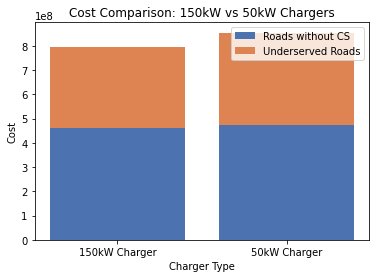

In [231]:


# Calculate the costs separately for each category
cost_of_150w_1 = total_150kw_needed * 1000000
cost_of_50w_1 = total_50kw_needed * 500000

cost_of_150w_2 = total_150kw_needed_2 * 1000000
cost_of_50w_2 = total_50kw_needed_2 * 500000

# Create a list of the charger types
charger_types = ['150kW Charger', '50kW Charger']

# Create a list of the corresponding costs for each category
costs_1 = [cost_of_150w_1, cost_of_50w_1]
costs_2 = [cost_of_150w_2, cost_of_50w_2]

# Create a bar plot for the first category
plt.bar(charger_types, costs_1, label='Roads without CS')

# Add a bar plot for the second category on top of the first one
plt.bar(charger_types, costs_2, bottom=costs_1, label='Underserved Roads')

plt.xlabel('Charger Type')
plt.ylabel('Cost')
plt.title('Cost Comparison: 150kW vs 50kW Chargers')
plt.legend()
plt.show()


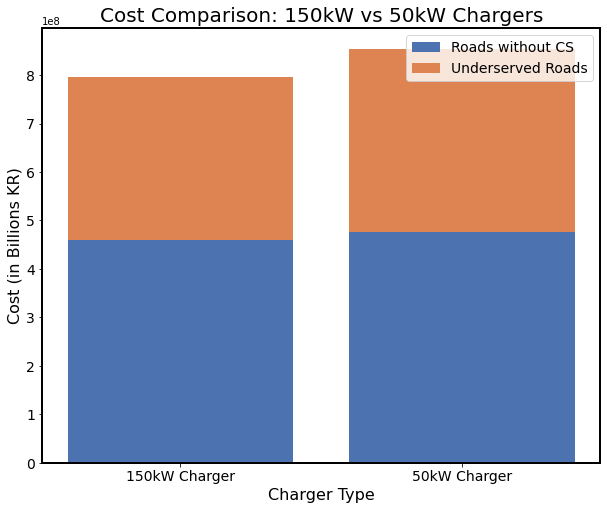

In [232]:
# Import the seaborn library for a nicer color palette
import seaborn as sns

# Set the color palette
sns.set_palette("deep")

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 8)) 

# Create a bar plot for the first category
ax.bar(charger_types, costs_1, label='Roads without CS')

# Add a bar plot for the second category on top of the first one
ax.bar(charger_types, costs_2, bottom=costs_1, label='Underserved Roads')

# Set the title and labels, and use larger text for these
ax.set_title('Cost Comparison: 150kW vs 50kW Chargers', fontsize=20)
ax.set_xlabel('Charger Type', fontsize=16)
ax.set_ylabel('Cost (in Billions KR)', fontsize=16)

# Make the tick labels larger
ax.tick_params(labelsize=14)

# Make the axes lines thicker
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# Show the legend with larger text
ax.legend(fontsize=14)

# Show the plot
plt.show()


In [233]:
#Why are we using 150kW and 50kW?
#Source: https://www.regjeringen.no/contentassets/a07ef2d3142344989dfddc75f5a92365/kunnskapsgrunnlag_1mars.pdf
#Source 2: Figur 2.3: https://www.regjeringen.no/contentassets/26d4c472862342b69e8d49803b45c36a/no/pdfs/nasjonal-ladestrategi.pdf
#Figure 6 from source, has data from (Nobil). The graph shows an increase in 150kW chargers, 50kW is stationary atm.

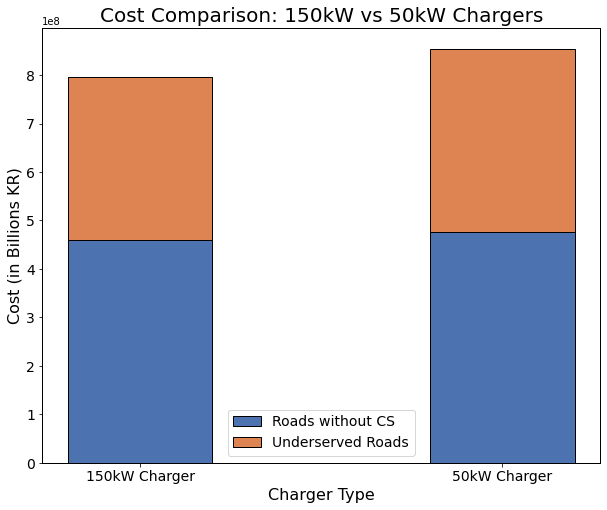

In [234]:
# Import the seaborn library for a nicer color palette
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
sns.set_palette("deep")

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 8)) 

# Create a bar plot for the first category
ax.bar(charger_types, costs_1, label='Roads without CS', width=0.4, edgecolor='black')

# Add a bar plot for the second category on top of the first one
ax.bar(charger_types, costs_2, bottom=costs_1, label='Underserved Roads', width=0.4, edgecolor='black')

# Set the title and labels, and use larger text for these
ax.set_title('Cost Comparison: 150kW vs 50kW Chargers', fontsize=20)
ax.set_xlabel('Charger Type', fontsize=16)
ax.set_ylabel('Cost (in Billions KR)', fontsize=16)

# Make the tick labels larger
ax.tick_params(labelsize=14)

# Make the axes lines thicker
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

# Show the legend with larger text
ax.legend(fontsize=14)

# Show the plot
plt.show()


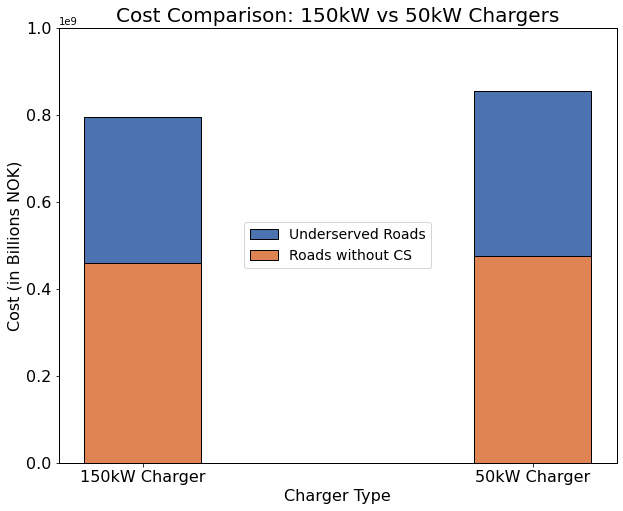

In [235]:
# Import the seaborn library for a nicer color palette
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
sns.set_palette("deep")

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 8)) 

# Add a bar plot for the second category on top of the first one
ax.bar(charger_types, costs_2, bottom=costs_1, label='Underserved Roads', width=0.3, edgecolor='black')

# Create a bar plot for the first category
ax.bar(charger_types, costs_1, label='Roads without CS', width=0.3, edgecolor='black')

# Set the title and labels, and use larger text for these
ax.set_title('Cost Comparison: 150kW vs 50kW Chargers', fontsize=20)
ax.set_xlabel('Charger Type', fontsize=16)
ax.set_ylabel('Cost (in Billions NOK)', fontsize=16)

# Set the Y-axis limits to 0 and 10
ax.set_ylim(0, 1000000000)

# Make the tick labels larger
ax.tick_params(labelsize=16)

# Make the axes lines thicker
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)

# Show the legend with larger text
ax.legend(fontsize=14, loc="center")

# Show the plot
plt.show()
